In [1]:
import pandas as pd
import preprocessings
from train import *
import text2vec
import helpfunctions
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [2]:
n_labels = 5

In [3]:
data = preprocessings.get_preprocessed_data("./data/US_videos_20.25.11.csv", "./data/glove.twitter.27B.25d.txt", n_labels)

Done. 1192095 words loaded!


In [4]:
data2 = preprocessings.get_preprocessed_data("./data/US_videos_20.29.11.csv", "./data/glove.twitter.27B.25d.txt", n_labels)

Done. 1192095 words loaded!


In [5]:
final_data = data.append(data2)

In [6]:
final_data.shape

(44153, 17)

In [7]:
final_data.drop_duplicates(subset=["video_id"],inplace=True)

In [8]:
final_data.shape

(40805, 17)

In [9]:
for i in range(n_labels):
    range_views = helpfunctions.get_views(data, i, n_labels)
    print(range_views)

[0, 30150]
[30150, 136491]
[136491, 586984]
[586984, 3598347]
[3598347, 5083028929]


In [10]:
X_final = final_data[["comments_disabled", "ratings_disabled","time_gap", "title_embedded", "tags_embedded", "description_embedded"]]
Y_final = final_data["label"]

<p> train the model with default logistic regression and default data, try different evaluating metrics </p>

<p>Fit PCA on one embedded feature to find out about how many components needed to preserve 0.9 information.</p>

In [7]:
scaler = StandardScaler()
pca = PCA(n_components=0.9).fit(scaler.fit_transform(np.stack(X["title_embedded"], axis = 0)))

In [8]:
pca.n_components_

17

<p> Three embedded matrices of title, tags and description have total of 150 dimension, therefore we need to reduce dimension using principal component analysis and see how the number of components affect the score of logistic regression and decision tree</p>

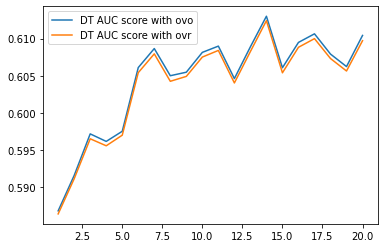

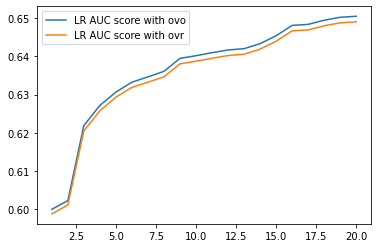

In [14]:
for k in ['DT', 'LR']:
    max_comp = 20
    roc_ovo = np.zeros(max_comp)
    roc_ovr = np.zeros(max_comp)
    for n in range(1,max_comp+1):
        X_reduced = dimension_reduction(X_final, n)
        roc_ovo[n-1], roc_ovr[n-1] = baseline(k, model_dict, X_reduced, Y_final)

    plt.plot(list(range(1,max_comp+1)), roc_ovo, label = f"{k} AUC score with ovo")
    plt.plot(list(range(1,max_comp+1)), roc_ovr, label = f"{k} AUC score with ovr")
    plt.legend()
    plt.show()

<p>We can see especially from logistic regression, the model performs better as dimension increases and there is a dramatic improvement from 1 to 10. To find the best number of dimension for tuning, we still need to delve further.</p>

<p>In addition, there is no much difference between AUC score measured by ovo and ovr,so ovr is prefered in the section of hyperparameter tuning, which has a much lower time complexity O(n) compared to that of ovo O($n^2$). </p>

In [ ]:
for i in range(10,15):
    X_reduced = dimension_reduction(X_final, i)
    print(f"Fitting models on embedded features with {i} dimensions")
    for label in model_dict:
        roc_ovo, roc_ovr = baseline(label, model_dict, X_reduced, Y_final)
        print(f"AUC score of {label}: {roc_ovr}")

Fitting models on embedded features with 10 dimensions
AUC score of RandomForest: 0.7955805886749077
AUC score of LR: 0.6387493742829048
AUC score of DT: 0.6019838164534159
AUC score of SVM: 0.714466835328102
AUC score of AdaBT: 0.7208469713443867
AUC score of GDBT: 0.7669197615362281
AUC score of XGB: 0.7862324280314829
Fitting models on embedded features with 11 dimensions
AUC score of RandomForest: 0.7933307286995688
AUC score of LR: 0.6394755254915314
AUC score of DT: 0.6040154769073481
AUC score of SVM: 0.7165843578114116
AUC score of AdaBT: 0.72420664835187
AUC score of GDBT: 0.7678088769046442
AUC score of XGB: 0.7875894729249923
Fitting models on embedded features with 12 dimensions
AUC score of RandomForest: 0.7939343078076868
AUC score of LR: 0.640217786403863
AUC score of DT: 0.6051488523709296


In [12]:
X_reduced = dimension_reduction(X_final, 15)
print(f"Fitting models on embedded features with {15} dimensions")
for label in model_dict:
    roc_ovo, roc_ovr = baseline(label, model_dict, X_reduced, Y_final)
    print(f"AUC score of {label}: {roc_ovr}")

Fitting models on embedded features with 15 dimensions
AUC score of RandomForest: 0.7892895734494518
AUC score of LR: 0.6439340940506458
AUC score of DT: 0.6053869921803543
AUC score of SVM: 0.7218863566731868
AUC score of AdaBT: 0.7218420427948534
AUC score of GDBT: 0.7707913907420522
AUC score of XGB: 0.7869413589868028


base line model: logsitric regression

In [16]:
x_final_reduced = dimension_reduction(X_final, 15)
chosen_params = simple_log_reg(x_final_reduced, Y_final)


grid: {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l2', 'l1'], 'multi_class': ['multinomial'], 'solver': ['saga'], 'max_iter': [500]}
tuned parameter of LogisticRegression:  {'C': 0.1, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}


In [17]:
baseline_lr = SklearnTrainer(LogisticRegression, params = chosen_params)
x_train, x_test, y_train, y_test = train_test_split(x_final_reduced, Y_final, train_size=0.8, random_state=42)
baseline_lr.fit(x_train, y_train)

In [18]:
predictions = baseline_lr.predict(x_test)
predict_prob = baseline_lr.predict_prob(x_test)
report = metrics.classification_report(y_test, predictions)
print(report)
auc_ovr = metrics.roc_auc_score(y_test, predict_prob, average="weighted", multi_class="ovr")
print(f"AUC score on test data: {auc_ovr}")
auc_ovr_train = metrics.roc_auc_score(y_train, baseline_lr.predict_prob(x_train), average="weighted", multi_class="ovr")
print(f"AUC score on train data: {auc_ovr_train}")

              precision    recall  f1-score   support

           0       0.29      0.45      0.35      1641
           1       0.27      0.18      0.22      1656
           2       0.32      0.25      0.28      1698
           3       0.27      0.15      0.20      1610
           4       0.39      0.58      0.47      1556

    accuracy                           0.32      8161
   macro avg       0.31      0.32      0.30      8161
weighted avg       0.31      0.32      0.30      8161

AUC score on test data: 0.6440684112927532
AUC score on train data: 0.6487220373128595


In [19]:
dt_chosen_params = simple_dt(x_final_reduced, Y_final)

grid: {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 8], 'min_samples_leaf': [1, 3, 5]}
tuned parameter of LogisticRegression:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [20]:
baseline_dt = SklearnTrainer(DecisionTreeClassifier, params = dt_chosen_params)
baseline_dt.fit(x_train, y_train)

In [21]:
baseline_dt.feature_importance()

array([0.00921746, 0.        , 0.65320673, 0.        , 0.        ,
       0.14801797, 0.00591036, 0.        , 0.        , 0.        ,
       0.0015904 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00777601, 0.        , 0.        , 0.00430023,
       0.00857953, 0.04001997, 0.        , 0.00317004, 0.        ,
       0.01354914, 0.00157436, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01019587,
       0.00457542, 0.00645304, 0.05917088, 0.        , 0.01494495,
       0.00774766, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [31]:
predictions = baseline_dt.predict(x_test)
predict_prob = baseline_dt.predict_prob(x_test)
report = metrics.classification_report(y_test, predictions)
print(report)
auc_ovr_dt = metrics.roc_auc_score(y_test, predict_prob, average="weighted", multi_class="ovr")
print(f"AUC score on test data: {auc_ovr_dt}")
auc_ovr_train_dt = metrics.roc_auc_score(y_train, baseline_dt.predict_prob(x_train), average="weighted", multi_class="ovr")
print(f"AUC score on train data: {auc_ovr_train_dt}")

              precision    recall  f1-score   support

           0       0.57      0.48      0.52      1641
           1       0.39      0.24      0.30      1656
           2       0.34      0.42      0.37      1698
           3       0.28      0.30      0.29      1610
           4       0.46      0.58      0.51      1556

    accuracy                           0.40      8161
   macro avg       0.41      0.40      0.40      8161
weighted avg       0.41      0.40      0.40      8161

AUC score on test data: 0.7195691659138763
AUC score on train data: 0.7342554529171799


<p> To save time, we choose the best three classifiers from the baseline, RandomForest, Gradient boosting and Xgboost for hyperparameter tuning. Because the overall performance of models do not improve much with higher dimension, we are going to continue with dimension 15 with each feature. For SVM, although it did a good job on the baseline model, the running time is extremely slow given its time complexity up to O(feature * $sample^3$). It will not be a good candidate if we are going to fit more data later on. </p>

In [6]:
X_reduced = dimension_reduction(X, 15)

In [9]:
param_grid = {"RF":{'n_estimators':[int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
                             'max_features':['sqrt','log2'],
                             'max_depth':[int(x) for x in np.linspace(10,100,10)],
                             'min_samples_split':[0.001, 0.01, 0.1],
                             'min_samples_leaf':[0.0001,0.001,0.01,0.1],
                             'random_state':[42]},
             "GBDT":{'learning_rate':[0.5, 0.25, 0.1, 0.05, 0.01],
                    'n_estimators':[int(x) for x in np.linspace(10,200,10)],
                    'subsample':[1, 0.8, 0.6],
                     'max_depth':[int(x) for x in np.linspace(5,50,10)],
                     'min_samples_split':[0.01,0.05,0.1,0.2],
                     'min_samples_leaf':[0.001,0.01,0.1,0.2],
                     'max_features':['sqrt','log2'],
                     'random_state':[42]
                    },
             "XGB":{"learning_rate":[0.01, 0.05, 0.1, 0.20],
                    'gamma':[0.1,0.5,1,10],
                    "max_depth":[ 3, 5, 7, 10],
                    "min_child_weight" : [ 1, 5, 10, 20],
                    'colsample_bytree':[0.2,0.5,0.7],
                    'subsample':[0.5,0.8],
                    'reg_lambda':[0,0.5,1],
                    'reg_alpha':[0,1,10,50,100],
                    'random_state':[42]
                   }}
clf_grid = {"RF":RandomForestClassifier,"GBDT":GradientBoostingClassifier, "XGB":xgb.XGBClassifier}

<p> For the sake of time, first use randomized search to limit max number of iterations. </p>

In [10]:
# cautious! this line takes hours
scores, params, time_cost, estimators = train(clf_grid, param_grid, X_reduced,Y,grid=False,n_itr=100)

Tuned Parameter of RF {'random_state': 42, 'n_estimators': 1000, 'min_samples_split': 0.001, 'min_samples_leaf': 0.0001, 'max_features': 'sqrt', 'max_depth': 80}
ROC score of RF on test set: 0.8450171842619243
Training time of RF: 47.17093515396118s
Tuned Parameter of GBDT {'subsample': 0.6, 'random_state': 42, 'n_estimators': 136, 'min_samples_split': 0.01, 'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'max_depth': 15, 'learning_rate': 0.05}
ROC score of GBDT on test set: 0.8394145847456281
Training time of GBDT: 26.210296154022217s
Tuned Parameter of XGB {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 1, 'random_state': 42, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.5}
ROC score of XGB on test set: 0.84237043378778
Training time of XGB: 24.590251922607422s


<p> It helped us narrow down the hyperparameter we need for exhaustive grid search. Compared to baseline model, all of them perform a bit better. Gradient boosting improves most by nearly 0.05. </p>

In [11]:
param_grid = {"RF":{'n_estimators':[1000,1500,2000],
                             'max_features':['sqrt'],
                             'max_depth':[80],
                             'min_samples_split':[3,5,7],
                             'min_samples_leaf':[1,2,4],
                             'random_state':[42]},
             "GBDT":{'learning_rate':[0.05],
                    'n_estimators':[136],
                    'subsample':[0.6],
                     'max_depth':[13,15,17],
                     'min_samples_split':[5,10,50],
                     'min_samples_leaf':[2,5,8],
                     'max_features':['sqrt'],
                     'random_state':[42]
                    },
             "XGB":{"learning_rate":[0.05],
                    'gamma':[0.01,0.05,0.1],
                    "max_depth":[10,20,50],
                    "min_child_weight" : [0.001,0.1,1],
                    'colsample_bytree':[0.5],
                    'subsample':[0.8,0.9,1],
                    'reg_lambda':[0.5],
                    'reg_alpha':[1],
                    'random_state':[42]
                   }}

<p> Then perform grid search on updated hyperparameter grid. </p>

In [12]:
# cautious, this line takes almost 10 hours
scores, params, time_cost, estimators = train(clf_grid, param_grid, X_reduced, Y)

Tuned Parameter of RF {'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1500, 'random_state': 42}
ROC score of RF on test set: 0.850445226464943
Training time of RF: 76.371915102005s
Tuned Parameter of GBDT {'learning_rate': 0.05, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 136, 'random_state': 42, 'subsample': 0.6}
ROC score of GBDT on test set: 0.8460582815407987
Training time of GBDT: 41.887561082839966s
Tuned Parameter of XGB {'colsample_bytree': 0.5, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 20, 'min_child_weight': 0.1, 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 1}
ROC score of XGB on test set: 0.8475248341406524
Training time of XGB: 47.11545515060425s


<p> Then we get the best hyperparameters for each model. Now, we can draw some graph regarding their time cost and performance on larger data set. </p>

In [14]:
# to do: define a function takes the above classifiers, parameters, data and data size
# plot trend of time cost/test score on metric.
# plot feature importance graph if the classifier support the feature.
# plot performance regarding dimension reduction via PCA

In [23]:
best_rf = SklearnTrainer(RandomForestClassifier, params = tuned_params["RandomForest"])
best_rf.fit(x_train, y_train)
rf_predict = best_rf.predict(x_test)

In [26]:
rf_report = metrics.classification_report(y_test, rf_predict)
print(rf_report)
auc_rf = metrics.roc_auc_score(y_test, best_rf.predict_prob(x_test), average="weighted", multi_class="ovr")
print(f"AUC score of RandomForest: {auc_rf}")

              precision    recall  f1-score   support

           0       0.61      0.64      0.62      1641
           1       0.46      0.37      0.41      1656
           2       0.44      0.36      0.40      1698
           3       0.43      0.44      0.43      1610
           4       0.54      0.72      0.62      1556

    accuracy                           0.50      8161
   macro avg       0.50      0.51      0.50      8161
weighted avg       0.49      0.50      0.49      8161

AUC score of RandomForest: 0.8060949213218692


In [29]:
best_gb = SklearnTrainer(GradientBoostingClassifier, params = tuned_params["GBDT"])
best_gb.fit(x_train, y_train)
gb_predict = best_gb.predict(x_test)
gb_report = metrics.classification_report(y_test, gb_predict)
print(gb_report)
auc_gb = metrics.roc_auc_score(y_test, best_gb.predict_prob(x_test), average="weighted", multi_class="ovr")
print(f"AUC score of Gradient Boost: {auc_gb}")

              precision    recall  f1-score   support

           0       0.62      0.61      0.62      1641
           1       0.42      0.38      0.40      1656
           2       0.42      0.36      0.39      1698
           3       0.42      0.43      0.42      1610
           4       0.55      0.68      0.61      1556

    accuracy                           0.49      8161
   macro avg       0.49      0.49      0.49      8161
weighted avg       0.48      0.49      0.49      8161

AUC score of Gradient Boost: 0.8010531098443465


In [30]:
best_xgb = SklearnTrainer(xgb.XGBClassifier, params = tuned_params["XGB"])
best_xgb.fit(x_train, y_train)
xgb_predict = best_xgb.predict(x_test)
xgb_report = metrics.classification_report(y_test, xgb_predict)
print(xgb_report)
auc_xgb = metrics.roc_auc_score(y_test, best_xgb.predict_prob(x_test), average="weighted", multi_class="ovr")
print(f"AUC score of xgboost: {auc_xgb}")

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      1641
           1       0.43      0.39      0.41      1656
           2       0.42      0.37      0.40      1698
           3       0.42      0.40      0.41      1610
           4       0.55      0.69      0.61      1556

    accuracy                           0.49      8161
   macro avg       0.49      0.50      0.49      8161
weighted avg       0.49      0.49      0.49      8161

AUC score of xgboost: 0.7996338810931308


In [32]:
stacking_estimators = [('rf',RandomForestClassifier(**tuned_params['RandomForest'])),
                       ('gb',GradientBoostingClassifier(**tuned_params['GBDT'])),
                      ('xgb', xgb.XGBClassifier(**tuned_params["XGB"]))]

In [33]:
stack_clf = StackingClassifier(stacking_estimators, n_jobs=-1, final_estimator = LogisticRegression(max_iter=500))
stack_clf.fit(x_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=80,
                                                       max_features='sqrt',
                                                       min_samples_split=3,
                                                       n_estimators=1500,
                                                       random_state=0)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=17,
                                                           max_features='sqrt',
                                                           min_samples_leaf=8,
                                                           min_samples_split=5,
                                                           n_estimators=136,
                                                           random_state=0,
             

In [35]:
predictions_stack = stack_clf.predict(x_test)
predict_prob_stack = stack_clf.final_estimator_.predict_proba(stack_clf.transform(x_test))
report_stack = metrics.classification_report(y_test, predictions_stack)
print(report_stack)
auc_ovr = metrics.roc_auc_score(y_test, predict_prob_stack, average="weighted", multi_class="ovr")
print(f"Stacking classifier's AUC score: {auc_ovr}")

              precision    recall  f1-score   support

           0       0.64      0.61      0.62      1641
           1       0.43      0.40      0.41      1656
           2       0.43      0.39      0.41      1698
           3       0.44      0.48      0.46      1610
           4       0.59      0.67      0.63      1556

    accuracy                           0.51      8161
   macro avg       0.51      0.51      0.51      8161
weighted avg       0.50      0.51      0.50      8161

Stacking classifier's AUC score: 0.8134560538898049
